In [26]:
using CSV, DataFrames, Statistics, Dates, Gadfly

# Manipulation des donnees meteo

In [27]:
meteo = CSV.read("data/meteo.csv", DataFrame)
rename!(meteo,:"Date/Time" => :Date, :"Mean Temp (°C)" => :Mean_Temp, :"Total Rain (mm)" => :Total_Rain, :"Total Snow (cm)" => :Total_Snow, :"Snow on Grnd (cm)" => :Snow_On_Ground)
meteo[!, :Year] = transform(meteo, :Date => ByRow(year) => :Date).Date
meteo[!, :Month] = transform(meteo, :Date => ByRow(month) => :Date).Date
meteo[!, :YearMonth] = transform(meteo, :Date => ByRow(yearmonth) => :Date).Date
meteo[!, :MonthDay] = transform(meteo, :Date => ByRow(monthday) => :Date).Date

first(meteo, 5)

5×9 DataFrame
 Row │ Date        Mean_Temp  Total_Rain  Total_Snow  Snow_On_Ground  Year   M ⋯
     │ Date        Float64?   Float64?    Float64?    Int64?          Int64  I ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 1999-01-01      -20.5         0.0         1.0               2   1999    ⋯
   2 │ 1999-01-02      -19.2         0.0         0.0               2   1999
   3 │ 1999-01-03       -8.5         1.2        11.4               7   1999
   4 │ 1999-01-04       -9.4         0.0         0.0               8   1999
   5 │ 1999-01-05      -14.3         0.0         0.0               8   1999    ⋯
                                                               3 columns omitted

### Creation d'une annee moyenne avec laquelle on va pouvoir completer les donnees manquantes

1) Regrouper par jour de l'annee pour faire des Df pour chaque jour de l'annee pour toutes les annees
2) Faire la moyenne de chaque colonne en ignorant les valeurs manquante (Ceci n'est pas trop grave puisqu'il y a toujours d'autre valeurs pour le meme jour d'annees differentes)

In [28]:
days = groupby(meteo, :"MonthDay")

meteo_daily_leap = DataFrame(MonthDay = Tuple[], Mean_Temp = Float64[], Total_Rain= Float64[], Total_Snow= Float64[], Snow_On_Ground = Float64[])  # On initialise un DataFrame vide

for day in days  # Pour chaque zone de chasse,
    push!(meteo_daily_leap, [day.MonthDay[1], mean(skipmissing(day.Mean_Temp)), mean(skipmissing(day.Total_Rain)), mean(skipmissing(day.Total_Snow)), mean(skipmissing(day.Snow_On_Ground))])
end

meteo_daily = meteo_daily_leap[Not([366]), :]
sort!(meteo_daily_leap, (:MonthDay))

first(meteo_daily, 5)

5×5 DataFrame
 Row │ MonthDay  Mean_Temp  Total_Rain  Total_Snow  Snow_On_Ground 
     │ Tuple     Float64    Float64     Float64     Float64        
─────┼─────────────────────────────────────────────────────────────
   1 │ (1, 1)     -6.68636    1.41818      1.70909         8.45455
   2 │ (1, 2)     -8.22273    0.318182     1.78182         8.72727
   3 │ (1, 3)     -7.04091    0.918182     2.52727         9.40909
   4 │ (1, 4)     -6.00909    1.52727      1.63636         9.86364
   5 │ (1, 5)     -6.73182    1.21818      1.2             9.68182

### Remplacement des donnees manquantes

Chaque donnee manquante dans la DF meteo sera remplacee par la valeur du jour approprie dans la DF moyenne.

In [29]:
year_months = groupby(meteo, :Year)

for year_month in year_months
    
    if isleapyear(year_month.Date[1])
        year_month.Snow_On_Ground .= coalesce.(year_month.Snow_On_Ground, meteo_daily_leap.Snow_On_Ground)
        year_month.Mean_Temp .= coalesce.(year_month.Mean_Temp, meteo_daily_leap.Mean_Temp)
        year_month.Total_Rain .= coalesce.(year_month.Total_Rain, meteo_daily_leap.Total_Rain)
        year_month.Total_Snow .= coalesce.(year_month.Total_Snow, meteo_daily_leap.Total_Snow)
    else
        year_month.Snow_On_Ground .= coalesce.(year_month.Snow_On_Ground, meteo_daily.Snow_On_Ground)
        year_month.Mean_Temp .= coalesce.(year_month.Mean_Temp, meteo_daily.Mean_Temp)
        year_month.Total_Rain .= coalesce.(year_month.Total_Rain, meteo_daily.Total_Rain)
        year_month.Total_Snow .= coalesce.(year_month.Total_Snow, meteo_daily.Total_Snow)
    end
    
end

meteo[!, :Snow_On_Ground] = convert.(Float64, meteo[:, :Snow_On_Ground]) #Conversion en float parceque le type s'est transforme en Real avec les manipulations

first(meteo, 5)

5×9 DataFrame
 Row │ Date        Mean_Temp  Total_Rain  Total_Snow  Snow_On_Ground  Year   M ⋯
     │ Date        Float64?   Float64?    Float64?    Float64         Int64  I ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 1999-01-01      -20.5         0.0         1.0             2.0   1999    ⋯
   2 │ 1999-01-02      -19.2         0.0         0.0             2.0   1999
   3 │ 1999-01-03       -8.5         1.2        11.4             7.0   1999
   4 │ 1999-01-04       -9.4         0.0         0.0             8.0   1999
   5 │ 1999-01-05      -14.3         0.0         0.0             8.0   1999    ⋯
                                                               3 columns omitted

### Ajout de 2013 au DF principal

Nous n'avons pas les donnees de 2013 donc il faut les remplacer par l'annee moyenne

In [30]:
date_iter = Date(2012,12,31)

days_2013 = [begin x = date_iter + Day(x) end for x in 1:365]

meteo_2013 = meteo_daily
meteo_2013[!, :Date] = days_2013

select!(meteo, Not([:Year, :Month, :YearMonth]))

meteo_clean = sort(outerjoin(meteo, meteo_2013, on = intersect(names(meteo), names(meteo_2013))), (:Date))


8401×6 DataFrame
  Row │ Date        Mean_Temp  Total_Rain  Total_Snow  Snow_On_Ground  MonthDa ⋯
      │ Date        Float64?   Float64?    Float64?    Float64         Tuple   ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 1999-01-01      -20.5         0.0         1.0             2.0  (1, 1)  ⋯
    2 │ 1999-01-02      -19.2         0.0         0.0             2.0  (1, 2)
    3 │ 1999-01-03       -8.5         1.2        11.4             7.0  (1, 3)
    4 │ 1999-01-04       -9.4         0.0         0.0             8.0  (1, 4)
    5 │ 1999-01-05      -14.3         0.0         0.0             8.0  (1, 5)  ⋯
    6 │ 1999-01-06       -7.1         0.0         3.1             8.0  (1, 6)
    7 │ 1999-01-07      -11.2         0.0         0.8            10.0  (1, 7)
    8 │ 1999-01-08      -12.8         0.0         5.2             8.0  (1, 8)
    9 │ 1999-01-09       -9.9         0.0        13.8            17.0  (1, 9)  ⋯
   10 │ 1999-01-10      -14.7         0.0         0.6            21.0  (1, 10)
   11 │ 1999-01-11      -15.6         0.0         0.6            20.0  (1, 11)
  ⋮   │     ⋮           ⋮          ⋮           ⋮             ⋮            ⋮    ⋱
 8392 │ 2021-12-22       -4.8         0.0         0.0             4.0  (12, 22
 8393 │ 2021-12-23      -12.3         0.0         0.0             4.0  (12, 23 ⋯
 8394 │ 2021-12-24      -10.2         0.0         0.0             4.0  (12, 24
 8395 │ 2021-12-25       -6.4         0.0         2.2             4.0  (12, 25
 8396 │ 2021-12-26       -2.2         0.0         0.6             4.0  (12, 26
 8397 │ 2021-12-27       -7.0         0.0         0.0             4.0  (12, 27 ⋯
 8398 │ 2021-12-28       -5.8         0.0         2.0             5.0  (12, 28
 8399 │ 2021-12-29       -5.2         0.0         0.0             5.0  (12, 29
 8400 │ 2021-12-30       -4.2         0.0         0.6             5.0  (12, 30
 8401 │ 2021-12-31       -1.7         0.0         0.2             6.0  (12, 31 ⋯
                                                  1 column and 8380 rows omitted

### Analyse exploratoire de l'hiver

creation d'un DF pour l'hiver de chaque annee

In [32]:
winter_start = [(12, 12), (12, 31)]
winter_end = [(01,01), (03, 01)]

meteo_hiver = filter(:Date => x ->(winter_start[1] < monthday(x) < winter_start[2]) || (winter_end[1] < monthday(x) < winter_end[2]), meteo_clean)

1754×6 DataFrame
  Row │ Date        Mean_Temp  Total_Rain  Total_Snow  Snow_On_Ground  MonthDa ⋯
      │ Date        Float64?   Float64?    Float64?    Float64         Tuple   ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 1999-01-02      -19.2         0.0         0.0            2.0   (1, 2)  ⋯
    2 │ 1999-01-03       -8.5         1.2        11.4            7.0   (1, 3)
    3 │ 1999-01-04       -9.4         0.0         0.0            8.0   (1, 4)
    4 │ 1999-01-05      -14.3         0.0         0.0            8.0   (1, 5)
    5 │ 1999-01-06       -7.1         0.0         3.1            8.0   (1, 6)  ⋯
    6 │ 1999-01-07      -11.2         0.0         0.8           10.0   (1, 7)
    7 │ 1999-01-08      -12.8         0.0         5.2            8.0   (1, 8)
    8 │ 1999-01-09       -9.9         0.0        13.8           17.0   (1, 9)
    9 │ 1999-01-10      -14.7         0.0         0.6           21.0   (1, 10) ⋯
   10 │ 1999-01-11      -15.6         0.0         0.6           20.0   (1, 11)
   11 │ 1999-01-12      -16.9         0.0         4.6           23.0   (1, 12)
  ⋮   │     ⋮           ⋮          ⋮           ⋮             ⋮            ⋮    ⋱
 1745 │ 2021-12-21       -2.4         0.0         1.2            5.0   (12, 21
 1746 │ 2021-12-22       -4.8         0.0         0.0            4.0   (12, 22 ⋯
 1747 │ 2021-12-23      -12.3         0.0         0.0            4.0   (12, 23
 1748 │ 2021-12-24      -10.2         0.0         0.0            4.0   (12, 24
 1749 │ 2021-12-25       -6.4         0.0         2.2            4.0   (12, 25
 1750 │ 2021-12-26       -2.2         0.0         0.6            4.0   (12, 26 ⋯
 1751 │ 2021-12-27       -7.0         0.0         0.0            4.0   (12, 27
 1752 │ 2021-12-28       -5.8         0.0         2.0            5.0   (12, 28
 1753 │ 2021-12-29       -5.2         0.0         0.0            5.0   (12, 29
 1754 │ 2021-12-30       -4.2         0.0         0.6            5.0   (12, 30 ⋯
                                                  1 column and 1733 rows omitted

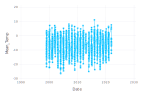

In [33]:
plot(meteo_hiver, x=:Date, y=:Mean_Temp, Geom.line, Geom.point)

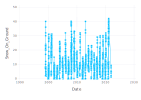

In [34]:
plot(meteo_hiver, x=:Date, y=:Snow_On_Ground, Geom.line, Geom.point)

In [37]:
hiver_annee = groupby(transform(meteo_hiver, :Date => ByRow(year) => :Date), :Date)

moy_hiver = combine(hiver_annee, [:Mean_Temp, :Total_Rain, :Total_Snow, :Snow_On_Ground] .=> mean)

first(moy_hiver, 5)

5×5 DataFrame
 Row │ Date   Mean_Temp_mean  Total_Rain_mean  Total_Snow_mean  Snow_On_Ground ⋯
     │ Int64  Float64         Float64          Float64          Float64        ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  1999        -6.74737         0.981579         1.64079               8. ⋯
   2 │  2000        -8.97403         0.823377         2.17922               9.
   3 │  2001        -7.35526         0.659211         1.67632              19.
   4 │  2002        -4.33421         0.381579         0.772368              3.
   5 │  2003       -10.075           0.7              1.56053               7. ⋯
                                                                1 column omitted

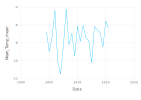

In [39]:
plot(moy_hiver, x=:Date, y=:Mean_Temp_mean, Geom.line)

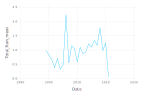

In [40]:
plot(moy_hiver, x=:Date, y=:Total_Rain_mean, Geom.line)

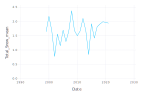

In [41]:
plot(moy_hiver, x=:Date, y=:Total_Snow_mean, Geom.line)

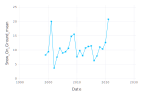

In [43]:
plot(moy_hiver, x=:Date, y=:Snow_On_Ground_mean, Geom.line, Geom.point)